# Kaggle Competiton | Telstra Network Disruptions

>We evaluate which parameters of Random Forest classifier provide the best score.

>The prediction is performed through Grid Search. Two datasets are generated in each run and two parameters are evaluated each time.

>The mean score between the two datasets is displayed in a heatmap.

>The choosen parameters will be used in run_predict.py for final prediction.

Go to the official page of the [Kaggle Competition.](https://www.kaggle.com/c/telstra-recruiting-network)

### Goal for this Notebook:
* Generate and evaluate predictions through Grid Search
* Compare scores obtained for Random Forest classifier parameters

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import grid_search
from scipy import stats
from data_modifier import *

%matplotlib inline

/usr/local/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


### 1. Handle Data

###### Load, Clean, Aggregate and Merge Data

In [2]:
event = pd.read_csv("../../../github_data/telstradisr_data/event_type.csv")
log = pd.read_csv("../../../github_data/telstradisr_data/log_feature.csv")
sample = pd.read_csv("../../../github_data/telstradisr_data/sample_submission.csv")
severity = pd.read_csv("../../../github_data/telstradisr_data/severity_type.csv")
resource = pd.read_csv("../../../github_data/telstradisr_data/resource_type.csv")
train = pd.read_csv("../../../github_data/telstradisr_data/train.csv")
test = pd.read_csv("../../../github_data/telstradisr_data/test.csv")

In [3]:
event['event_type'] = event['event_type'].str.split(' ').str[1]
log['log_feature'] = log['log_feature'].str.split(' ').str[1]
severity['severity_type'] = severity['severity_type'].str.split(' ').str[1]
resource['resource_type'] = resource['resource_type'].str.split(' ').str[1]
test['location'] = test['location'].str.split(' ').str[1]
train['location'] = train['location'].str.split(' ').str[1]

In [4]:
tables = [log,event,severity,resource] 
names = ['log','event','severity','resource'] 
for i in range(len(tables)):
    check = unique_column(tables[i],tables[i].columns[-1])
    
    # AGGREGATE CATEGORICAL VALUES INTO A DICTIO
    if check == False:
        if len(tables[i].columns) == 2:
            a = tables[i].groupby([tables[i].columns[-2],tables[i].columns[-1]]).agg({tables[i].columns[-1]:'count'})
            a.index.names = ['id','cat']
            a = a.reset_index()
            a = a.set_index('cat')
                    
            # take care that keys are still integers in the dict            
            a = a.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-1]].items()})
            tables[i] = pd.DataFrame(a,columns=[tables[i].columns[-1]])
            
        elif len(tables[i].columns) == 3:
            a = tables[i].groupby([tables[i].columns[-3],tables[i].columns[-2],tables[i].columns[-1]]).agg({tables[i].columns[-1]:'count',tables[i].columns[-2]:'count'})
            a.index.names = ['id','cat1','cat2']
            a = a.reset_index()
            a = a.set_index('cat1')
            b = a.set_index('cat2')
            
            # take care that keys are still integers in the dict
            a = a.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-1]].items()})
            b = b.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-2]].items()})
            log1 = pd.DataFrame(a,columns=[tables[i].columns[-1]])
            log2 = pd.DataFrame(b,columns=[tables[i].columns[-2]])
event = tables[1]
severity = tables[2]
resource = tables[3]

In [5]:
train = train.merge(event, left_on='id', right_index=True, how='left')
train = train.merge(severity, left_on='id', right_index=True, how='left')
train = train.merge(resource, left_on='id', right_index=True, how='left')
train = train.merge(log1, left_on='id', right_index=True, how='left')
train = train.merge(log2, left_on='id', right_index=True, how='left')

###### Split Data

In [6]:
tr_a, te_a = train_test_split(train, train_size = 0.8)
y_train = tr_a.fault_severity
y_test = te_a.fault_severity
tr_a.drop(tr_a.columns[[0,2]], axis=1, inplace=True)
te_a.drop(te_a.columns[[0,2]], axis=1, inplace=True)

###### Predict with different combination of Parameters

In [7]:
param_grid_1 =  {'randomforestclassifier__max_depth': [8,16],
               'randomforestclassifier__criterion': ['gini'], 
               'randomforestclassifier__n_estimators':[5,20], 
               'randomforestclassifier__max_leaf_nodes':[None], 
               'randomforestclassifier__min_samples_split':[2],
               'randomforestclassifier__min_samples_leaf':[10], 
               'randomforestclassifier__min_weight_fraction_leaf':[0.0],
               'randomforestclassifier__n_jobs':[1]
}
param_grid_2 =  {'randomforestclassifier__max_depth': [4,8],
               'randomforestclassifier__criterion': ['gini'], 
               'randomforestclassifier__n_estimators':[5], 
               'randomforestclassifier__max_leaf_nodes':[None], 
               'randomforestclassifier__min_samples_split':[2],
               'randomforestclassifier__min_samples_leaf':[1,10], 
               'randomforestclassifier__min_weight_fraction_leaf':[0.0],
               'randomforestclassifier__n_jobs':[1]
}
param_grid_3 =  {'randomforestclassifier__max_depth': [8],
               'randomforestclassifier__criterion': ['gini'], 
               'randomforestclassifier__n_estimators':[10,100], 
               'randomforestclassifier__max_leaf_nodes':[None], 
               'randomforestclassifier__min_samples_split':[2],
               'randomforestclassifier__min_samples_leaf':[1], 
               'randomforestclassifier__min_weight_fraction_leaf':[0.0],
               'randomforestclassifier__n_jobs':[1]
}
param_grid_4 =  {'randomforestclassifier__max_depth': [8],
               'randomforestclassifier__criterion': ['gini'], 
               'randomforestclassifier__n_estimators':[2,5], 
               'randomforestclassifier__max_leaf_nodes':[None], 
               'randomforestclassifier__min_samples_split':[2],
               'randomforestclassifier__min_samples_leaf':[1,4], 
               'randomforestclassifier__min_weight_fraction_leaf':[0.0],
               'randomforestclassifier__n_jobs':[1]
}

* Grid Search in two datasets 

In [8]:
call = PipelineTelstra(RandomForestClassifier)
gs = grid_search.GridSearchCV(call, param_grid_4, cv=2, n_jobs=1, pre_dispatch='n_jobs') 
gs = gs.fit(tr_a,y_train)

pipeline done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

Once we create a model out of the train data, we check the mean score for the different combinations of the Random Forest classifier parameters that we have chosen.

In this case we will visualize the scores in a heat map where the two values of the two parameters are combined.

In [9]:
sco = gs.grid_scores_
sco

[mean: 0.65396, std: 0.00232, params: {'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_weight_fraction_leaf': 0.0, 'randomforestclassifier__n_estimators': 2, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_leaf_nodes': None, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_jobs': 1},
 mean: 0.66988, std: 0.01214, params: {'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_weight_fraction_leaf': 0.0, 'randomforestclassifier__n_estimators': 5, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_leaf_nodes': None, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_jobs': 1},
 mean: 0.69597, std: 0.00345, params: {'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_weight_fraction_leaf': 0.0, 'rando

In [10]:
meanv = np.zeros(len(sco))
deptv = np.zeros(len(sco),dtype=np.int)
estiv = np.zeros(len(sco),dtype=np.int)
deptk = [i for i in sco[0].parameters.keys()][4]
estik = [i for i in sco[0].parameters.keys()][3]

l = 0
while l < len(sco):
    mean = sco[l].mean_validation_score
    par = sco[l].parameters.values()
    values = [v for v in par]
    meanv[l] = mean
    estiv[l] = values[3]
    deptv[l] = values[4]
    l += 1

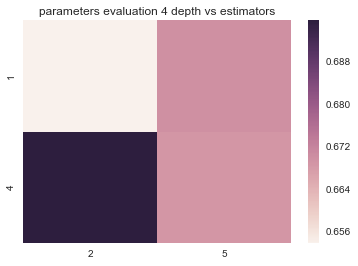

In [11]:
ma = np.matrix([[meanv[0], meanv[1]], [meanv[2], meanv[3]]], dtype=np.float64)
scores = pd.DataFrame(ma,columns=np.unique(estiv),index=np.unique(deptv))
ax = sns.heatmap(scores)
ax.set_title('parameters evaluation 4 depth vs estimators')
fig = ax.get_figure()
fig.savefig("par_eval_3_leaf1_4_esti2_5.png")

In [12]:
y_predict = gs.predict(te_a)

DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.


In the combination of parameters of "param_grid_4", the highest score is for 2 number of estimators and 4 minimum samples per leaf. 

The best combination of parameters will be choosen for runing the final prediction with run_predict.py. The results will be written into results.csv and uploaded.